In [1]:
# 1. Kütüphaneler ve Ayarlar
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- WINDOWS İÇİN KRİTİK YAMA ---
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# --------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset

# Cihaz seçimi (Ekran kartı varsa onu kullanır)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Kurulum Tamam. Kullanılan Cihaz: {device}")

✅ Kurulum Tamam. Kullanılan Cihaz: cpu


In [2]:
# ==========================================
# 2. VERİ YOLU VE YÜKLEME
# ==========================================
path = "deniz_anasi"

# Klasör Kontrolü
if not os.path.exists(path):
    print(f"\n❌ HATA: '{path}' isimli klasör bulunamadı!")
    print("Lütfen 'deniz_anasi' klasörünü, bu dosyanın yanına taşıyın.")
    raise SystemExit("Klasör bulunamadığı için işlem durduruldu.")
else:
    print(f"✅ '{path}' klasörü bulundu, veri analizi başlıyor...")

# Klasör yapısını anlama
potential_train_dirs = ["Train_Test_Valid/Train", "TRAIN", "train", "Train"]
potential_test_dirs = ["Train_Test_Valid/Test", "TEST", "test", "Test"]

train_dir = None
test_dir = None

for t_dir in potential_train_dirs:
    full_path = os.path.join(path, t_dir)
    if os.path.exists(full_path):
        train_dir = full_path
        break

for t_dir in potential_test_dirs:
    full_path = os.path.join(path, t_dir)
    if os.path.exists(full_path):
        test_dir = full_path
        break

DATA_SPLIT_NEEDED = False
if train_dir and test_dir:
    print(f"📂 Hazır Eğitim Klasörü: {train_dir}")
    print(f"📂 Hazır Test Klasörü: {test_dir}")
else:
    print("ℹ️ Hazır Train/Test alt klasörleri bulunamadı. Ana dizin otomatik bölünecek.")
    train_dir = path
    DATA_SPLIT_NEEDED = True

# Veri Dönüşümleri
img_size = (128, 128)
train_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 32

try:
    if DATA_SPLIT_NEEDED:
        full_dataset = datasets.ImageFolder(root=train_dir, transform=None)
        class_names = full_dataset.classes
        num_data = len(full_dataset)
        indices = list(range(num_data))
        split = int(np.floor(0.2 * num_data))
        np.random.shuffle(indices)
        train_idx, test_idx = indices[split:], indices[:split]
        
        train_subset_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
        test_subset_data = datasets.ImageFolder(root=train_dir, transform=test_transform)
        
        train_data = Subset(train_subset_data, train_idx)
        test_data = Subset(test_subset_data, test_idx)
        print(f"✂️ Veri Seti Otomatik Bölündü: {len(train_data)} Eğitim, {len(test_data)} Test")
    else:
        train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
        test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)
        class_names = train_data.classes

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    num_classes = len(class_names)
    print(f"✅ Sınıflar ({num_classes} adet): {class_names}")

except Exception as e:
    print(f"\n❌ Veri yüklenirken hata: {e}")
    raise SystemExit()

✅ 'deniz_anasi' klasörü bulundu, veri analizi başlıyor...
📂 Hazır Eğitim Klasörü: deniz_anasi\Train_Test_Valid/Train
📂 Hazır Test Klasörü: deniz_anasi\Train_Test_Valid/Test
✅ Sınıflar (6 adet): ['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']


In [3]:
# 3. CNN Model Mimarisi
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNNModel(num_classes=num_classes).to(device)
print(f"🧠 Model oluşturuldu. Çıkış katmanı {num_classes} sınıf.")

🧠 Model oluşturuldu. Çıkış katmanı 6 sınıf.


In [4]:
# 4. Eğitim Döngüsü
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_acc = 0.0
EPOCHS = 12 

print(f"\n🚀 Eğitim Başlıyor ({EPOCHS} Epoch)...")

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    scheduler.step()
    
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    acc_train = 100 * correct_train / total_train
    acc_val = 100 * correct_val / total_val
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(acc_train)
    val_accs.append(acc_val)
    
    print(f"Epoch {epoch+1}/{EPOCHS} -> Train Loss: {avg_train_loss:.4f} | Val Acc: %{acc_val:.2f}")

    if acc_val > best_acc:
        best_acc = acc_val
        torch.save(model.state_dict(), "en_iyi_jellyfish_modeli.pth")
        print(f"   💾 Yeni rekor! Model kaydedildi.")

print(f"\n🎉 Eğitim Bitti! En yüksek başarı: %{best_acc:.2f}")


🚀 Eğitim Başlıyor (12 Epoch)...
Epoch 1/12 -> Train Loss: 1.7450 | Val Acc: %40.00
   💾 Yeni rekor! Model kaydedildi.
Epoch 2/12 -> Train Loss: 1.4625 | Val Acc: %50.00
   💾 Yeni rekor! Model kaydedildi.
Epoch 3/12 -> Train Loss: 1.3116 | Val Acc: %62.50
   💾 Yeni rekor! Model kaydedildi.
Epoch 4/12 -> Train Loss: 1.2029 | Val Acc: %52.50
Epoch 5/12 -> Train Loss: 1.0997 | Val Acc: %60.00
Epoch 6/12 -> Train Loss: 1.0538 | Val Acc: %62.50
Epoch 7/12 -> Train Loss: 0.9930 | Val Acc: %62.50
Epoch 8/12 -> Train Loss: 0.9648 | Val Acc: %67.50
   💾 Yeni rekor! Model kaydedildi.
Epoch 9/12 -> Train Loss: 0.9578 | Val Acc: %65.00
Epoch 10/12 -> Train Loss: 0.9324 | Val Acc: %65.00
Epoch 11/12 -> Train Loss: 0.9470 | Val Acc: %65.00
Epoch 12/12 -> Train Loss: 0.9283 | Val Acc: %65.00

🎉 Eğitim Bitti! En yüksek başarı: %67.50


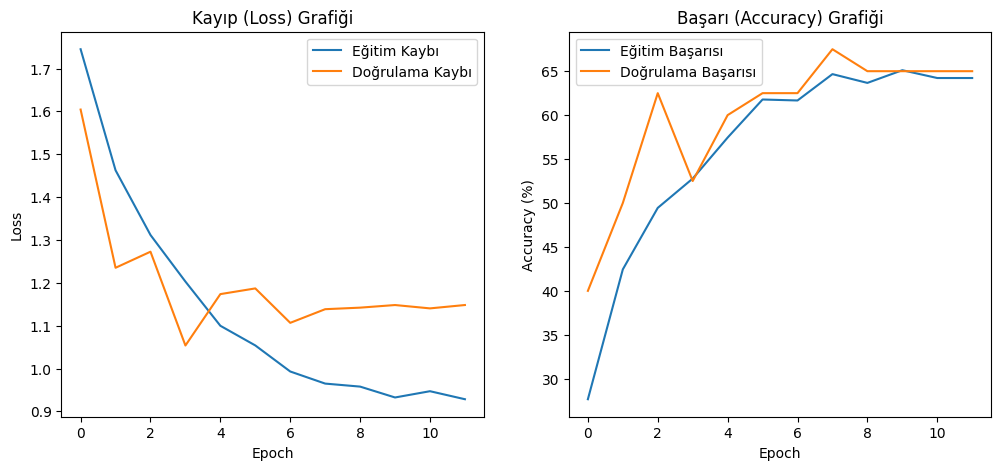

In [5]:
# 5. Grafikleri Çizdir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Eğitim Kaybı')
plt.plot(val_losses, label='Doğrulama Kaybı')
plt.title('Kayıp (Loss) Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Eğitim Başarısı')
plt.plot(val_accs, label='Doğrulama Başarısı')
plt.title('Başarı (Accuracy) Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


📸 Rastgele bir test resmi hazırlanıyor...
💾 En iyi model ağırlıkları yüklendi.


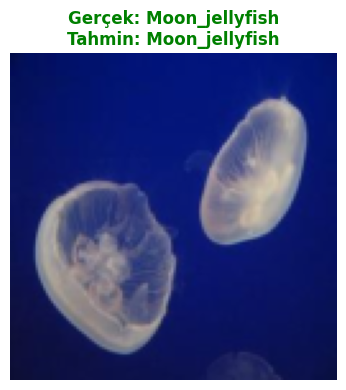

In [6]:
# ==========================================
# 6. TAHMİNLERİ GÖRSELLEŞTİRME (KÜÇÜK BOYUTLU TEK RESİM)
# ==========================================

def tahminleri_tek_resimli_goster(loader, model, class_names):
    model.eval() # Modeli test moduna al
    
    # Test verisinden bir paket (batch) al
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    # Cihaza gönder
    images = images.to(device)
    labels = labels.to(device)
    
    # Modelden tahmin iste
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    # --- GÖRSELLEŞTİRME KISMI (Küçük Boyut) ---
    
    # Boyutu küçülttük: (4, 4) yaptık. Daha da küçültmek istersen (3, 3) yapabilirsin.
    plt.figure(figsize=(4, 4))
    
    # Sadece paketteki ilk resmi (indeks 0) alıyoruz
    i = 0
        
    # Görüntüyü işle
    img = images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5
    
    plt.imshow(img)
    
    gercek_isim = class_names[labels[i]]
    tahmin_isim = class_names[preds[i]]
    
    renk = 'green' if gercek_isim == tahmin_isim else 'red'
    
    # Yazı boyutlarını da biraz küçülttük
    plt.title(f"Gerçek: {gercek_isim}\nTahmin: {tahmin_isim}", 
              color=renk, fontsize=12, fontweight='bold')
    plt.axis('off') 
        
    plt.tight_layout()
    plt.show()

# --- Çalıştırma Kısmı ---
print("\n📸 Rastgele bir test resmi hazırlanıyor...")

if os.path.exists("en_iyi_jellyfish_modeli.pth"):
    model.load_state_dict(torch.load("en_iyi_jellyfish_modeli.pth"))
    print("💾 En iyi model ağırlıkları yüklendi.")

tahminleri_tek_resimli_goster(test_loader, model, class_names)

📂 İşleniyor: c:\Users\ibrahim\Desktop\download.jpg


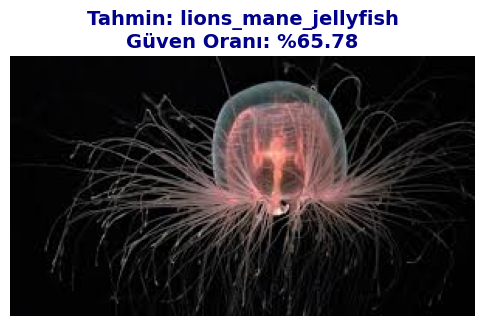

🔍 SONUÇ: Model bu resmin %65.78 ihtimalle 'lions_mane_jellyfish' olduğunu düşünüyor.


In [7]:
# ==========================================
# 7. TEK RESİM SORGULAMA (YÜZDELİK ORANLI)
# ==========================================

# 👇 RESMİN TAM YOLUNU BURAYA YAPIŞTIR
RESIM_YOLU = r"c:\Users\ibrahim\Desktop\download.jpg"


def tek_resim_tahmin_et(resim_yolu, model, class_names):
    """
    Verilen resmi tahmin eder ve doğruluk yüzdesini (güven oranını) gösterir.
    """
    # 1. Dosya Kontrolü
    if not os.path.exists(resim_yolu):
        print(f"\n❌ HATA: Dosya bulunamadı: {resim_yolu}")
        return

    # 2. Resmi Aç
    try:
        image = Image.open(resim_yolu).convert('RGB')
    except Exception as e:
        print(f"❌ Resim hatası: {e}")
        return

    # 3. Modele Hazırla
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # 4. Tahmin ve Olasılık Hesabı
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        
        # Olasılıkları hesapla (Softmax)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        
        # En yüksek olasılığı ve indeksini al
        guven_orani, predicted_idx = torch.max(probabilities, 1)
        
        tahmin_tur = class_names[predicted_idx.item()]
        yuzde = guven_orani.item() * 100 # Örn: 0.95 -> 95.0
        
    # 5. Sonucu Göster
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    
    # Başlığa yüzdeyi ekliyoruz
    baslik = f"Tahmin: {tahmin_tur}\nGüven Oranı: %{yuzde:.2f}"
    
    plt.title(baslik, fontsize=14, color='darkblue', fontweight='bold')
    plt.axis('off')
    plt.show()
    
    print(f"🔍 SONUÇ: Model bu resmin %{yuzde:.2f} ihtimalle '{tahmin_tur}' olduğunu düşünüyor.")

# --- ÇALIŞTIRMA ---
print(f"📂 İşleniyor: {RESIM_YOLU}")

if 'class_names' in globals() and model:
    tek_resim_tahmin_et(RESIM_YOLU, model, class_names)
else:
    print("⚠️ Lütfen önce yukarıdaki eğitim kodlarını çalıştırın.")